# Energy generation prediction 

In [30]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [31]:
print(torch.__version__)

1.13.1+cu116


## Exploratory Data Analysis (EDA)

In [41]:
# Define data root directory
data_dir = "./data"
print(os.listdir(data_dir))

['Net generation from hydro for United States Lower 48 (region) hourly - UTC time.csv', 'Net generation from nuclear for United States Lower 48 (region) hourly - UTC time.csv', 'Net generation from coal for United States Lower 48 (region) hourly - UTC time.csv', 'Net generation from other for United States Lower 48 (region) hourly - UTC time.csv', 'Net generation from natural gas for United States Lower 48 (region) hourly - UTC time.csv', 'Net generation from petroleum for United States Lower 48 (region) hourly - UTC time.csv']


In [42]:
pd.read_csv(os.path.join(data_dir, "/content/data/Net generation from natural gas for United States Lower 48 (region) hourly - UTC time.csv")).head()

,date,megawatthours
0,2018-07-01 05:00:00,66791
1,2018-07-01 06:00:00,92199
2,2018-07-01 07:00:00,89001
3,2018-07-01 08:00:00,101095
4,2018-07-01 09:00:00,97000


## Create training instances by moving sliding window

In [43]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

## Integrate files to build the training set


In [44]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 4

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["date"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["date"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["date"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["date"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["date"].dayofyear, axis=1)
    df = df.sort_values("date").drop("date", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing Net generation from hydro for United States Lower 48 (region) hourly - UTC time.csv ...
(32526, 90, 5) (32526, 1)
Processing Net generation from nuclear for United States Lower 48 (region) hourly - UTC time.csv ...
(32526, 90, 5) (32526, 1)
Processing Net generation from coal for United States Lower 48 (region) hourly - UTC time.csv ...
(32526, 90, 5) (32526, 1)
Processing Net generation from other for United States Lower 48 (region) hourly - UTC time.csv ...
(32526, 90, 5) (32526, 1)


In [45]:
df.head()

,megawatthours,hour,dayofweek,month,dayofyear
0,5226,5,6,7,182
1,6460,6,6,7,182
2,5983,7,6,7,182
3,7037,8,6,7,182
4,7050,9,6,7,182


## Pytorch data loaders/generators

In [46]:
batch_size = 500

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [47]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (117096, 90, 5), Batch Size: 500, # of iterations per epoch: 234


In [48]:
# release some memory
del train_x, train_y

In [49]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


In [50]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [51]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=3,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

## Train and Save an LSTM model

In [52]:
n_hidden = 256
n_layers = 2
n_epochs = 10
print_every = 100
lr = 0.001
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model
Epoch 1 - Step: 100/234 - Average Loss for Epoch: 0.03737634757533669
Epoch 1 - Step: 200/234 - Average Loss for Epoch: 0.020837785339681433
Epoch 1/10 Done, Total Loss: 0.018201873913849108
Time Elapsed for Epoch: 23.201765640999994 seconds
Epoch 2 - Step: 100/234 - Average Loss for Epoch: 0.0017046293430030347
Epoch 2 - Step: 200/234 - Average Loss for Epoch: 0.0014685272183851338
Epoch 2/10 Done, Total Loss: 0.0014032187914420078
Time Elapsed for Epoch: 21.65506459400001 seconds
Epoch 3 - Step: 100/234 - Average Loss for Epoch: 0.0009099057427374647
Epoch 3 - Step: 200/234 - Average Loss for Epoch: 0.000822429564432241
Epoch 3/10 Done, Total Loss: 0.0007969929143173508
Time Elapsed for Epoch: 21.24514463899999 seconds
Epoch 4 - Step: 100/234 - Average Loss for Epoch: 0.0006267366983229295
Epoch 4 - Step: 200/234 - Average Loss for Epoch: 0.000581092800712213
Epoch 4/10 Done, Total Loss: 0.0005767078017746297
Time Elapsed for Epoch: 21.666501321 second

In [53]:
torch.save(lstm_model.state_dict(), "./models/lstm_model.pt")

# Evaluating models


In [54]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

## Load the LSTM model

In [55]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [56]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation



In [57]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [58]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

## Evaluate performance of LSTM

In [59]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 29.56680219699996
sMAPE: 0.735%


In [60]:
len(
    lstm_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

4

In [61]:
states_list = list(test_x.keys())

In [62]:
states_list

['Net generation from hydro for United States Lower 48 (region) hourly - UTC time.csv',
 'Net generation from nuclear for United States Lower 48 (region) hourly - UTC time.csv',
 'Net generation from coal for United States Lower 48 (region) hourly - UTC time.csv',
 'Net generation from other for United States Lower 48 (region) hourly - UTC time.csv']

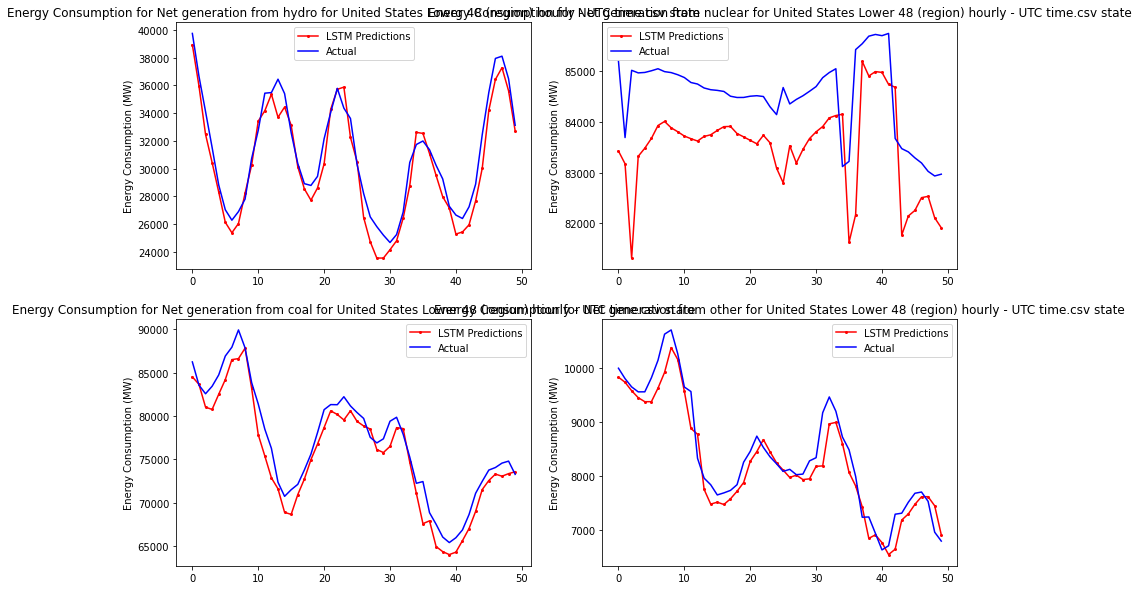

In [64]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(
    lstm_outputs[0][-50:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[2][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(lstm_outputs[3][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[3][:50], color="b", label="Actual")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.ylabel("Energy Consumption (MW)")
plt.legend()
plt.show()
